# Table of Contents

* [Setup Environment](#section1)
* [Prepare Data](#section2)
* [Basic Topic Model](#section3)
* [Extracting Topics](#section4)
* [Topics over Time](#section5)
* [Visualize Topics over Time](#section6)

# Setup Environment <a class=anchor id=section1></a>

In [2]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential --yes

In [3]:
%%capture
!pip install bertopic
!pip install farm-haystack
!pip install spacy
!pip install gensim
!pip install sagemaker_pyspark
!python -m spacy download en_core_web_sm

In [4]:
import re
import string
import pickle
import logging
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from nltk.corpus import stopwords
from haystack.nodes import PreProcessor
from nltk.corpus import PlaintextCorpusReader
from haystack.utils import convert_files_to_docs
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel

pio.renderers.default='iframe'
logging.getLogger("haystack.utils.preprocessing").setLevel(logging.ERROR)

In [5]:
import nltk

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
nltk.download('omw-1.4')
token_pattern = re.compile(r"(?u)\b\w\w+\b")
sentence_model = SentenceTransformer("all-distilroberta-v1")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if (len(t) > 3 and re.match("[a-z].*", t) and re.match(token_pattern, t)) or (t=='ai')
        ]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [11]:
output_path = "BERT_DTM/"
sources = ['CLEANSED/1950-1959', 'CLEANSED/1960-1969', 'CLEANSED/1970-1979', 'CLEANSED/1980-1989', 
          'CLEANSED/1990-1999', 'CLEANSED/2000-2009', 'CLEANSED/2010-2019']
stop_words = stopwords.words('english')
common_words = ['from', 'subject', 're', 'edu', 'use', 'said', 'find', 'still', 'take', 'year', 'first', 'be', 'am', 
                'are', 'is', 'was', 'were', 'being', 'can', 'could', 'do', 'did', 'does', 'doing', 'have', 'had', 
                'has', 'having', 'may', 'might', 'must', 'shall', 'should', 'will', 'would', 'still', 'going', 'never', 
                'incb21', 'outst21', '000c8', 'sfas', 'rev11', 'inct', 'amer', 'thet', 'inds_inct', 'adrt', 'natl', 
                'benihana_natl', 'tofruzen', 'indst', 'finl', 'inc10', 'amer_commun', 'incn', 'said', 'like', 'sept', 
                'mon', 'tues', 'wed', 'thu', 'fri', 'sat', 'sun', 'east', 'meany', 'corp', 'intl', 'inds', 'pas', 'return', 
                'trela', 'foot', 'time', 'named', 'also']
stop_words.extend(common_words)

# Prepare Data <a class=anchor id=section2></a>

In [12]:
# Remove copyright parts from articles
def remove_copyright_footer(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('reproduced with permission of the copyright owner.', '')
    sentence = sentence.replace('further reproduction prohibited without permission.', '')
    return sentence.replace('further reproduction is prohibited without permission.', '')

In [13]:
docs = []
timestamps = []
for source in sources:
    print("Processing {}".format(source.split("/")[1]))
    all_docs = convert_files_to_docs(dir_path=source)
    selected_docs = [doc for doc in all_docs if len(doc.content.split()) >= 10]
    preprocessor = PreProcessor(
        clean_empty_lines=True,
        clean_whitespace=True,
        clean_header_footer=True,
        split_by=None
    )
    data = [item.content for item in preprocessor.process(selected_docs)]
    # Remove Links
    data = [re.sub(r'http\S+', '', sent) for sent in data]
    # Remove footer
    data = [remove_copyright_footer(sent) for sent in data]
    # Fix spaces
    data = [sent.strip() for sent in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove special characters
    data = [re.sub(r'[^\x00-\x7f]',r'', sent) for sent in data]
    # # Remove some punctuations
    data = [item.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for item in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    processed_docs = [re.sub("\'", "", sent) for sent in data]
    print(f"Number of input files: {len(all_docs)}\n"+
          f"Number of selected files: {len(selected_docs)}\n"+
          f"Number of output files: {len(processed_docs)}")
    docs.extend(processed_docs)
    timestamps.extend([source.split("-")[1]]*len(processed_docs))

Processing 1950-1959



Number of input files: 1051
Number of selected files: 1051
Number of output files: 1051
Processing 1960-1969



Number of input files: 2900
Number of selected files: 2900
Number of output files: 2900
Processing 1970-1979



Number of input files: 1258
Number of selected files: 1258
Number of output files: 1258
Processing 1980-1989



Number of input files: 1771
Number of selected files: 1753
Number of output files: 1753
Processing 1990-1999



Number of input files: 1520
Number of selected files: 1368
Number of output files: 1368
Processing 2000-2009



Number of input files: 2010
Number of selected files: 2009
Number of output files: 2009
Processing 2010-2019



Number of input files: 2852
Number of selected files: 2852
Number of output files: 2852


In [14]:
print(len(docs))
print(len(timestamps))

13191
13191


# Basic Topic Model <a class=anchor id=section3></a>

To perform Dynamic Topic Modeling with BERTopic we will first need to create a basic topic model using all articles. The temporal aspect will be ignored as we are, for now, only interested in the topics that reside in those articles. 

In [12]:
def training(docs, docs_embeddings, cluster_size=100):
    vectorizer_model= CountVectorizer(stop_words=stop_words, tokenizer=LemmaTokenizer())
    # Set the random state in the UMAP model to prevent stochastic behavior 
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=cluster_size, metric='euclidean', prediction_data=True)
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics="auto", 
                           vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics, probs = topic_model.fit_transform(docs, docs_embeddings)
    
    ##### Calculate Coherence
    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, probs in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_npmi')
    coherence_score = coherence_model.get_coherence()

    return topic_model, topics, probs, coherence_score

In [13]:
def draw_graph(start, limit, step, c_npmi, title):
    # Show graph
    x = range(start, limit, step)
    plt.plot(x, c_npmi)
    plt.title(title)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Coherence score")
    plt.legend(("c_npmi"), loc='best')
    plt.show()
    maximum = max(c_npmi)
    indices = [i for i, v in enumerate(c_npmi) if v == maximum]
    print("A maximum {} score of {} was achieved at K={}".format("c_npmi", maximum, indices[0]+1))
    # Return the index
    return indices[0]

In [14]:
# Create embeddings
embeddings = sentence_model.encode(docs, show_progress_bar=True)

In [15]:
with open('bert_dtm_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [16]:
# Create topic model
start, limit, step = 10, 100, 10
topic_models = []
coherences = []
topics = []
probs = []

for i in range(start, limit, step):
    topic_model, topic, prob, coherence = training(docs, embeddings, i)
    topic_models.append(topic_model)
    topics.append(topic)
    probs.append(prob)
    coherences.append(coherence)

2022-08-17 16:57:23,790 - BERTopic - Reduced dimensionality
2022-08-17 16:57:50,628 - BERTopic - Clustered reduced embeddings
2022-08-17 17:03:53,955 - BERTopic - Reduced number of topics from 222 to 176
2022-08-17 17:07:04,412 - BERTopic - Reduced dimensionality
2022-08-17 17:07:11,787 - BERTopic - Clustered reduced embeddings
2022-08-17 17:12:55,442 - BERTopic - Reduced number of topics from 117 to 59
2022-08-17 17:15:55,950 - BERTopic - Reduced dimensionality
2022-08-17 17:15:59,842 - BERTopic - Clustered reduced embeddings
2022-08-17 17:21:35,135 - BERTopic - Reduced number of topics from 81 to 40
2022-08-17 17:24:27,158 - BERTopic - Reduced dimensionality
2022-08-17 17:24:29,933 - BERTopic - Clustered reduced embeddings
2022-08-17 17:30:04,719 - BERTopic - Reduced number of topics from 61 to 22
2022-08-17 17:32:47,356 - BERTopic - Reduced dimensionality
2022-08-17 17:32:49,482 - BERTopic - Clustered reduced embeddings
2022-08-17 17:38:25,675 - BERTopic - Reduced number of topics f

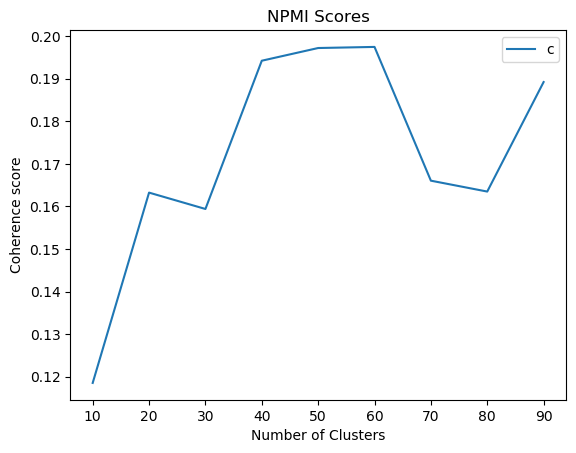

A maximum c_npmi score of 0.19748270484645503 was achieved at K=6


In [17]:
model_index = draw_graph(start, limit, step, coherences, "NPMI Scores")

In [18]:
topic_model, topic, prob, coherence = topic_models[model_index], topics[model_index], probs[model_index], coherences[model_index]
hierarchical_topics = topic_model.hierarchical_topics(docs, topic)

100%|██████████| 16/16 [00:00<00:00, 95.37it/s] 


In [19]:
!rm -r BERT_DTM/
!mkdir BERT_DTM

rm: cannot remove 'BERT_DTM/': No such file or directory


In [20]:
topic_model.save(output_path+"bert_dtm_model")
with open(output_path+'bert_dtm_timestamps.pkl', 'wb') as f:
    pickle.dump(timestamps, f)
with open(output_path+'bert_dtm_prob.pkl', 'wb') as f:
    pickle.dump(prob, f)
with open(output_path+'bert_dtm_coherence.pkl', 'wb') as f:
    pickle.dump(coherence, f)
with open(output_path+'bert_dtm_topics.pkl', 'wb') as f:
    pickle.dump(topic, f)
with open(output_path+'bert_dtm_hierarchical_topics.pkl', 'wb') as f:
    pickle.dump(hierarchical_topics, f)
with open(output_path+'bert_dtm_docs.pkl', 'wb') as f:
    pickle.dump(docs, f)

# Extracting Topics <a class=anchor id=section4></a>

In [21]:
topic_model = BERTopic.load(output_path+"bert_dtm_model")
with open(output_path+'bert_dtm_timestamps.pkl', 'rb') as f:
    timestamps = pickle.load(f)
with open(output_path+'bert_dtm_prob.pkl', 'rb') as f:
    prob = pickle.load(f)
with open(output_path+'bert_dtm_coherence.pkl', 'rb') as f:
    coherence = pickle.load(f)
with open(output_path+'bert_dtm_topics.pkl', 'rb') as f:
    topic = pickle.load(f)
with open(output_path+'bert_dtm_hierarchical_topics.pkl', 'rb') as f:
    hierarchical_topics = pickle.load(f)
with open(output_path+'bert_dtm_docs.pkl', 'rb') as f:
    docs = pickle.load(f)

We can then extract most frequent topics:

In [22]:
freq = topic_model.get_topic_info()
freq.head(10)

,Topic,Count,Name
0,-1,5072,-1_company_state_people_business
1,0,4414,0_company_system_worker_state
2,1,647,1_theater_music_directed_closed
3,2,497,2_ship_port_union_cargo
4,3,460,3_union_newspaper_publisher_news
5,4,404,4_exchange_stock_trading_market
6,5,267,5_earns_income_sale_share
7,6,218,6_train_transit_subway_authority
8,7,174,7_graduated_father_bride_mother
9,8,170,8_driving_vehicle_car_driver


> -1 refers to all outliers and should typically be ignored. 

Next, let's take a look at a frequent topic that were generated:

In [23]:
topic_nr = freq.iloc[4]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('union', 0.0731016813702368),
 ('newspaper', 0.06871316118686954),
 ('publisher', 0.04850410368701502),
 ('news', 0.045028115602255496),
 ('printer', 0.04286375347977118),
 ('guild', 0.04076541360726225),
 ('strike', 0.036105171178548424),
 ('york', 0.03411614314828983),
 ('contract', 0.03208073374742765),
 ('paper', 0.028758231887172945)]

We can visualize the basic topics that were created with the Intertopic Distance Map. This allows us to judge visually whether the basic topics are sufficient before proceeding to creating the topics over time. 

In [24]:
topic_model.visualize_topics()

# Topics over Time <a class=anchor id=section5></a>

Before we start with the Dynamic Topic Modeling step, it is important that you are satisfied with the topics that were created previously. We are going to be using those specific topics as a base for Dynamic Topic Modeling. Thus, this step will essentially show you how the topics that were defined previously have evolved over time. 

There are a few important parameters that you should take note of, namely:
* `docs`
  * These are the articles that we are using
* `topics`
  * The topics that we have created before
* `timestamps`
  * The timestamp of each article/document
* `global_tuning`
  * Whether to average the topic representation of a topic at time *t* with its global topic representation
* `evolution_tuning`
  * Whether to average the topic representation of a topic at time *t* with the topic representation of that topic at time *t-1*
* `nr_bins`
  * The number of bins to put our timestamps into. It is computationally inefficient to extract the topics at thousands of different timestamps. Therefore, it is advised to keep this value below 20. 


In [25]:
print(len(docs))
print(len(topic))
print(len(timestamps))

13191
13191
13191


In [16]:
topics_over_time = topic_model.topics_over_time(docs=docs, 
                                                topics=topic, 
                                                timestamps=timestamps, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=7)

7it [01:35, 13.71s/it]


# Visualize Topics over Time <a class=anchor id=section6></a>

After having created our `topics_over_time`, we will have to visualize those topics as accessing them becomes a bit more difficult with the added temporal dimension. 

To do so, we are going to visualize the distribution of topics over time based on their frequency. Doing so allows us to see how the topics have evolved over time. Make sure to hover over any point to see how the topic representation at time *t* differs from the global topic representation.

## Original Frequency

In [17]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50, normalize_frequency=False)

## Normalized

In [18]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50, normalize_frequency=True)